In [54]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import skimage
import skimage.morphology
from skimage.measure import label   
import math
import pandas as pd
import re
from pathlib import Path
import imageio
import scipy as sp
import shutil
from tqdm import tqdm
import os
from PIL import Image

In [64]:
df = pd.read_csv('metadata/mass_case_description_train_set.csv')
df.columns

Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'mass shape', 'mass margins',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')

In [65]:
print(df['pathology'].value_counts())
df['pathology_simplified'] = df['pathology'].str.split('_').apply(lambda x: x[0])
df['pathology_simplified'].value_counts()

MALIGNANT                  637
BENIGN                     577
BENIGN_WITHOUT_CALLBACK    104
Name: pathology, dtype: int64


BENIGN       681
MALIGNANT    637
Name: pathology_simplified, dtype: int64

Conclusion: Folder name for ROI mask and image file are different, we're saving these under ROI mask names when generating large patches

In [66]:
# output using simple name
df["output_patch_path"] = df["image file path"].str.split('/').apply(lambda x: "-".join([
    x[1],x[2]]))
df["output_patch_path"] = df["output_patch_path"] + "-abnorm_" + df['abnormality id'].astype(str) + '.png'
df["output_patch_path"]  = df['pathology_simplified'] + "_MASS/" +  df["output_patch_path"]
df["output_patch_path"].iloc[0]

'MALIGNANT_MASS/1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994-1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515-abnorm_1.png'

Conversion algorithm

In [67]:
AREA_MULTIPLIER = 2

cbis_img_folder = Path("/Users/Ryan/HarvardCodes/MIT6862/cbis-ddsm-png-reorganized")
output_patch_folder = Path("/Users/Ryan/HarvardCodes/MIT6862/cbis-ddsm-large-patch/train/")

def minMaxNormalise(img):
    norm_img = (img - img.min()) / (img.max() - img.min())
    return norm_img

def clahe(img, clip=2.0, tile=(8, 8)):
    img = cv2.normalize(
        img,
        None,
        alpha=0,
        beta=255,
        norm_type=cv2.NORM_MINMAX,
        dtype=cv2.CV_32F,
    )
    img_uint8 = img.astype("uint8")
    clahe_create = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    clahe_img = clahe_create.apply(img_uint8)
    return clahe_img

def process_full_mamo(img):
    return clahe(minMaxNormalise(img))

def create_im_path_to_open(path_from_manifest):
    return str(cbis_img_folder/path_from_manifest.replace('.dcm','.png')).strip()

def calculate_padded_coordinates(xmin,xmax,ymin,ymax,im_width,im_height):
    # Test Y
    #calculate_padded_coordinates(5,6,2,8,10,20)
    #calculate_padded_coordinates(5,6,10,18,10,20)
    # Test X
    #calculate_padded_coordinates(2,7,8,12,10,20)
    #calculate_padded_coordinates(4,9,8,12,10,20)

    xdiff = xmax-xmin
    ydiff = ymax-ymin
    # use same padding for both x and y so that we can obtain a square patch
    xpad = int(np.ceil(xdiff/AREA_MULTIPLIER))
    ypad = int(np.ceil(ydiff/AREA_MULTIPLIER))
    xpad = max([xpad,ypad])
    ypad = max([xpad,ypad])
    
    if (xmin-xpad < 0) and (xmax+xpad > im_width):
        xmin_padded = 0
        xmax_padded = im_width
    elif xmin-xpad < 0: 
        # run outside boundary
        xmin_padded = 0
        xmax_padded = min([xmax+xpad-(xmin-xpad),im_width])
    elif xmax+xpad > im_width: 
        xmin_padded = xmin-xpad-(xmax+xpad-im_width)
        xmax_padded = im_width
    else:
        xmin_padded = xmin-xpad
        xmax_padded = xmax+xpad
    xmin_padded = max([xmin_padded,0])
    xmax_padded = min([xmax_padded,im_width])
    
    if (ymin-ypad < 0) and (ymax+ypad > im_height):
        ymin_padded = 0
        ymax_padded = im_height
    elif ymin-ypad < 0: 
        # run outside boundary
        ymin_padded = 0
        ymax_padded = min([ymax+ypad-(ymin-ypad),im_height])
    elif ymax+ypad > im_height: 
        ymin_padded = ymin-ypad-(ymax+ypad-im_height)
        ymax_padded = im_height
    else:
        ymin_padded = ymin-ypad
        ymax_padded = ymax+ypad
    ymin_padded = max([ymin_padded,0])
    ymax_padded = min([ymax_padded,im_height])
    
    return xmin_padded,xmax_padded,ymin_padded,ymax_padded
                      
#Processing For Loop
for idx,row in df.iterrows():
    mask_path = create_im_path_to_open(row["ROI mask file path"])
    img_path = create_im_path_to_open(row["image file path"])
    
    image = imageio.imread(img_path)
    mask = imageio.imread(mask_path)
    if len(np.unique(mask)) > 2: # cropped and ROI mask filename was switched
        mask_path = create_im_path_to_open(row["cropped image file path"])
        mask = imageio.imread(mask_path)
    
    #image = process_full_mamo(image)
    im_height,im_width = image.shape # np transposed the array
    if image.shape != mask.shape:
        print("Dim not equal ",mask_path)
    
    # np transposed the array
    cols,rows = np.where(mask>0)
    xmin = min(rows); xmax = max(rows); ymin = min(cols); ymax = max(cols)
    input_patch = image[ymin:ymax,xmin:xmax]
        
    xmin_padded,xmax_padded,ymin_padded,ymax_padded = calculate_padded_coordinates(
        xmin,xmax,ymin,ymax,im_width,im_height)
                      
    output_patch = image[ymin_padded:ymax_padded,xmin_padded:xmax_padded]
    
    outpath = output_patch_folder/row["output_patch_path"]
    if not outpath.parent.exists(): outpath.parent.mkdir(parents=True)
    imageio.imwrite(outpath,output_patch)

Dim not equal  /Users/Ryan/HarvardCodes/MIT6862/cbis-ddsm-png-reorganized/Mass-Training_P_00059_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.401398924711581741339345765413987838707/1.3.6.1.4.1.9590.100.1.2.203970065112706924324370021454096282600/000000.png
Dim not equal  /Users/Ryan/HarvardCodes/MIT6862/cbis-ddsm-png-reorganized/Mass-Training_P_00059_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.242921529611868736516328754073569063603/1.3.6.1.4.1.9590.100.1.2.213479805111756800235140829670343680695/000000.png
Dim not equal  /Users/Ryan/HarvardCodes/MIT6862/cbis-ddsm-png-reorganized/Mass-Training_P_00108_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.416906050610434891137095973180851386209/1.3.6.1.4.1.9590.100.1.2.167721256311930226218015781691859713018/000000.png
Dim not equal  /Users/Ryan/HarvardCodes/MIT6862/cbis-ddsm-png-reorganized/Mass-Training_P_00108_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.48299118010320886325355731231792274722/1.3.6.1.4.1.9590.100.1.2.312064575313543515220300745352630857321/000000.png
Dim not equ

Dim not equal  /Users/Ryan/HarvardCodes/MIT6862/cbis-ddsm-png-reorganized/Mass-Training_P_01115_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.251621955312555857125103543333117059339/1.3.6.1.4.1.9590.100.1.2.397878670112258535539834295382406058317/000000.png
Dim not equal  /Users/Ryan/HarvardCodes/MIT6862/cbis-ddsm-png-reorganized/Mass-Training_P_01115_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.166899960211694189337098054463827041384/1.3.6.1.4.1.9590.100.1.2.191581431611130104818482996532202750166/000000.png
Dim not equal  /Users/Ryan/HarvardCodes/MIT6862/cbis-ddsm-png-reorganized/Mass-Training_P_01182_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.220021828812125223913598237970848064134/1.3.6.1.4.1.9590.100.1.2.23469712812014256806861933360722981844/000000.png
Dim not equal  /Users/Ryan/HarvardCodes/MIT6862/cbis-ddsm-png-reorganized/Mass-Training_P_01182_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.156553832811320150424894439692040433290/1.3.6.1.4.1.9590.100.1.2.218276781510398310040036064503120593339/000000.png
Dim not e

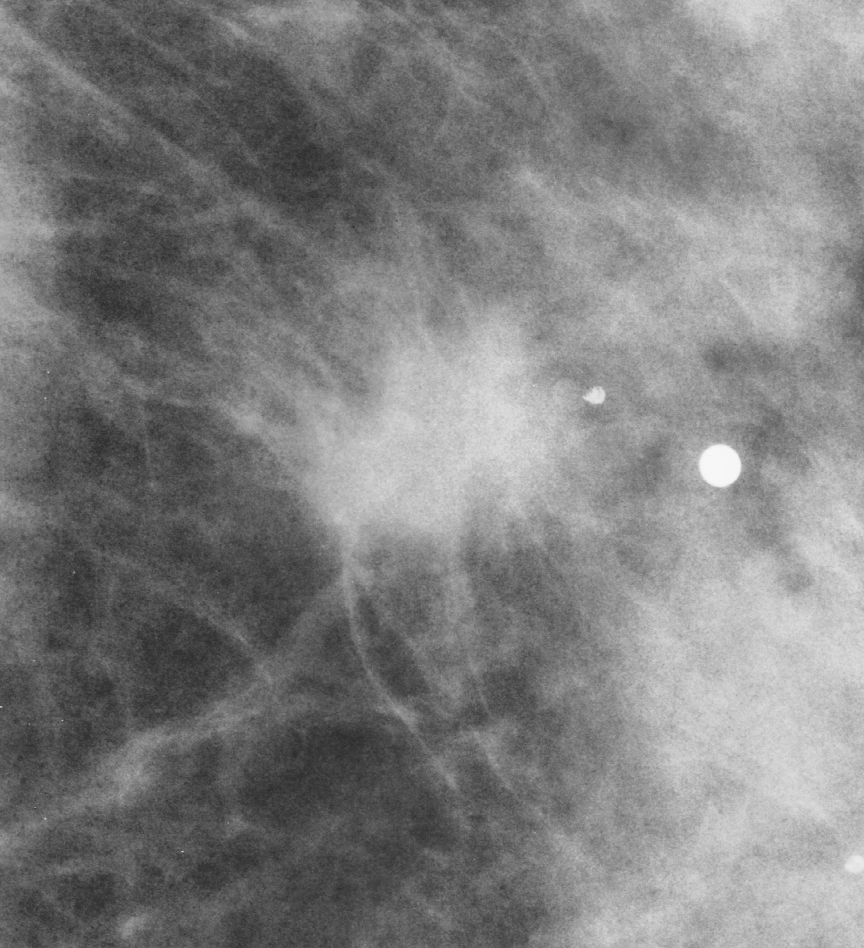

In [103]:
Image.fromarray(output_patch)

In [98]:
mask.shape,image.shape

((4808, 3024), (4808, 3024))

In [99]:
output_patch.shape,input_patch.shape

((948, 864), (474, 390))